# Guided Project: Finding Heavy Traffic Indicators on I-94

W tym projekcie wykonamy analizę zbioru danych o ruchu na autostradzie międzystanowej I-94.

Celem naszej analizy jest określenie kilku wskaźników dużego natężenia ruchu na I-94. Wskaźnikami tymi mogą być: 
* rodzaj pogody, 
* pora dnia, 
* pora tygodnia, itp.

Zaczniemy od wczytania danych oraz potrzebnych bibliotek.

In [ ]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00492/Metro_Interstate_Traffic_Volume.csv.gz'

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

df = pd.read_csv(url)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48204 entries, 0 to 48203
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   holiday              48204 non-null  object 
 1   temp                 48204 non-null  float64
 2   rain_1h              48204 non-null  float64
 3   snow_1h              48204 non-null  float64
 4   clouds_all           48204 non-null  int64  
 5   weather_main         48204 non-null  object 
 6   weather_description  48204 non-null  object 
 7   date_time            48204 non-null  object 
 8   traffic_volume       48204 non-null  int64  
dtypes: float64(3), int64(2), object(4)
memory usage: 3.3+ MB


W zbiorze mamy 9 kolumn oraz 48 tysięcy różnych wartości, przy czym nie ma brakujących wartości w kolumnach.

## Analyzing Traffic Volume

Analizę zaczniemy od zbadania rozkładu kolumny traffic_volume.

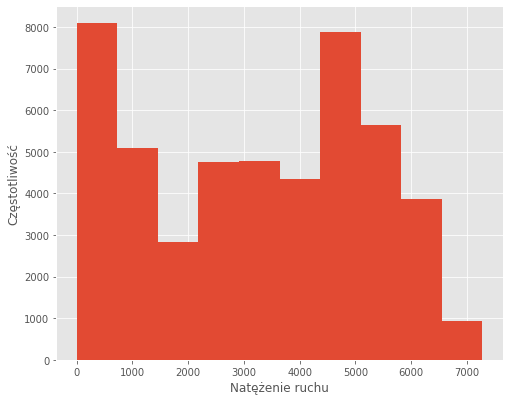

In [ ]:
plt.figure(figsize=(8,6.5))

plt.style.use('ggplot')
df['traffic_volume'].plot.hist()
plt.ylabel('Częstotliwość')
plt.xlabel('Natężenie ruchu')
plt.show()

In [ ]:
df['traffic_volume'].describe()

count    48204.000000
mean      3259.818355
std       1986.860670
min          0.000000
25%       1193.000000
50%       3380.000000
75%       4933.000000
max       7280.000000
Name: traffic_volume, dtype: float64

Średnia wartość kolumny traffic_volume wynosi 3258.82. Oznacza to, że średnie zakorkowanie tej części autostrady to około 3259 aut. 25% wszystkich korków to 1193 aut, natomiat 75% to już 4933 auta. 

Można sprawdzić różnice w zakorkowaniu podczas dnia (gdy aut powinno przejeżdzać więcej) oraz podczas nocy (kiedy aut normalnie przejeżda mniej).



## Day and night

Musimy podzielić zbiór na dwa podzbiory (dzień i noc). Zanim do tego przejdziemy, przekonwertujemy kolumny na obiekt date_time i wyodrębnimy miesiące do nowej kolumny.

In [ ]:
df['date_time'] = pd.to_datetime(df['date_time'])
df['month'] = df['date_time'].dt.month
df['month'] = df['month']

In [ ]:
df.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume,month
0,None,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545,10
1,None,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516,10
2,None,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767,10
3,None,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026,10
4,None,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918,10


Z platformy https://www.worlddata.info/america/usa/sunset.php pobierzemy średnie godziny światła dziennego na dzień, tzn. average daylight per month. Dane z tej strony pochodzą dla Ameryki, ja je wykorzystam w określeniu średniego czasu dla danych z projektu.  

In [ ]:
daylight_start = {1: '07:23:00' , 2: '06:57:00', 3: '07:17:00', 4: '06:29:00', 5: '05:53:00', 6: '05:40:00', 7: '05:53:00',
                  8: '06:20:00', 9: '06:48:00', 10: '07:16:00', 11: '06:49:00', 12: '07:18:00'}
daylight_end = {1: '17:51:00' , 2: '17:46:00', 3: '19:16:00', 4: '19:46:00', 5: '20:15:00', 6: '20:36:00', 7: '20:34:00',
                8: '20:04:00', 9: '19:18:00', 10: '18:31:00', 11: '16:55:00', 12: '16:48:00'}

In [ ]:
df['day_start'] = df['month'].map(daylight_start)
df['day_end'] = df['month'].map(daylight_end)
df['day_start'] = pd.to_datetime(df['day_start']).dt.time
df['day_end'] = pd.to_datetime(df['day_end']).dt.time

In [ ]:
df.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume,month,day_start,day_end
0,None,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545,10,07:16:00,18:31:00
1,None,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516,10,07:16:00,18:31:00
2,None,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767,10,07:16:00,18:31:00
3,None,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026,10,07:16:00,18:31:00
4,None,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918,10,07:16:00,18:31:00


Mamy stworzone nowe kolumny takie jak:
* month
* day_start
* day_end

Musimy jeszcze rozdzielić godziny pomiędzy dniem a nocą. Zrobimy to za pomocą filter_day, w której będziemy sprawdzać czy jest dzień, jeśli dana wartość mieści się w podanym zakresie godzinowym (dla nas jest to pomiędzy wschodem a zachodem słońca).

In [ ]:
filter_day = ((df['date_time'].dt.time >= df['day_start']) & (df['date_time'].dt.time <= df['day_end']))

In [ ]:
df["Day/Night"] = np.where(filter_day == True, "Day", "Night")

In [ ]:
df.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume,month,day_start,day_end,Day/Night
0,None,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545,10,07:16:00,18:31:00,Day
1,None,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516,10,07:16:00,18:31:00,Day
2,None,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767,10,07:16:00,18:31:00,Day
3,None,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026,10,07:16:00,18:31:00,Day
4,None,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918,10,07:16:00,18:31:00,Day


Wyizolowaliśmy dzień i noc, dlatego możemy przejść do dalszej analizy.

In [ ]:
day = df[df['Day/Night'] == "Day"]
night = df[df['Day/Night'] == "Night"]

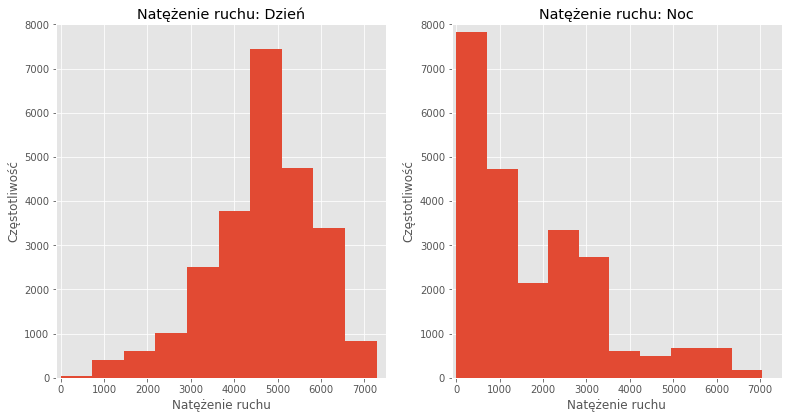

In [ ]:
plt.figure(figsize=(13,6.5))

plt.subplot(1, 2, 1)
plt.hist(day['traffic_volume'])
plt.xlim(-100, 7500)
plt.ylim(0, 8000)
plt.title('Natężenie ruchu: Dzień')
plt.ylabel('Częstotliwość')
plt.xlabel('Natężenie ruchu')

plt.subplot(1, 2, 2)
plt.hist(night['traffic_volume'])
plt.xlim(-100, 7500)
plt.ylim(0, 8000)
plt.title('Natężenie ruchu: Noc')
plt.ylabel('Częstotliwość')
plt.xlabel('Natężenie ruchu')

plt.show()

In [ ]:
day['traffic_volume'].describe()

count    24798.000000
mean      4652.703121
std       1205.634960
min          0.000000
25%       4041.000000
50%       4758.000000
75%       5466.000000
max       7280.000000
Name: traffic_volume, dtype: float64

Histogram dla dnia jest **lewoskośny**. To oznacza, że więcej wartości jest większych. Wartość w ciągu dnia jest wysoka, tzn. jest duże natężenie w ruchu. 50% wszystkich obserwacji jest większa od 4758.

In [ ]:
night['traffic_volume'].describe()

count    23406.000000
mean      1784.096044
std       1535.163900
min          0.000000
25%        511.000000
50%       1179.000000
75%       2744.000000
max       7055.000000
Name: traffic_volume, dtype: float64

Histogram dla nocy jest **prawoskośny**. Tutaj sytuacja jest odwrotna niż za dnia i większość wartości natężenia ruchu jest niska. 50% wartości jest większa od 1179. W 75% czasu przejeżdzało tylko 2744 lub więcej aut.

## Time Indicators

Innym wskaźnikiem dużego natężenia ruchu jest czas. Natężenie może się zmieniać w określonym miesiącu, w określonym dniu lub o określonej porze dnia.

Przyjrzymy się nastepującym czynnikom:

* Miesiąc
* Dzień tygodnia
* Pora dnia

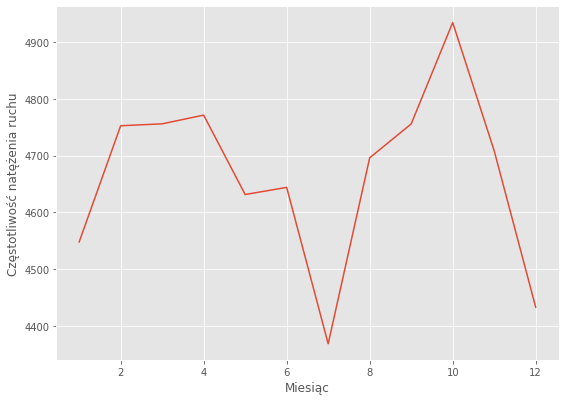

In [ ]:
plt.figure(figsize=(9,6.5))
by_month = day.groupby('month').mean()
by_month['traffic_volume'].plot.line()
plt.ylabel('Częstotliwość natężenia ruchu')
plt.xlabel('Miesiąc')
plt.show()

Najwięcej obserwacji odnotowano w 10 miesiącu, czyli w październiku. Drastyczny spadek odnotowanych wartości nastąpił w 7 miesiącu, czyli lipcu. Średnie natężenie ruchu to wartość od 4200 do 5000 aut.

Można by przyjąć, że w miesiące letnie aut będzie więcej, po obserwacji tego wykresu zauważamy, że jednak te zimniejsze miesiące mają większą częstotliwość. Warto się temu przyjrzeć.

Najbardziej zagadkowym miesiącem jest lipiec, w niej odnotowano najmniejsze wartości. Spójrzmy na ten miesiąc w okresie rocznym.

In [ ]:
day['year'] = day['date_time'].dt.year

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


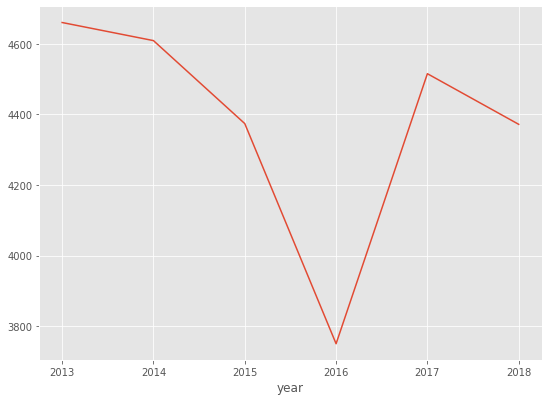

In [ ]:
plt.figure(figsize=(9,6.5))
day[day['month'] == 7].groupby('year').mean()['traffic_volume'].plot.line()
plt.show()

Spadek nastąpił głównie w roku 2016. Być może coś wyjątkowego wydarzyło się właśnie w tym roku. Możliwym powodem tego mogłaby być przebudowa odbywająca się w tym roku na odcinku tej autostrady. W internecie znajdują się artykuły na ten temat, [przykład](https://www.crainsdetroit.com/article/20160728/NEWS/160729841/). 

Nie jest wykluczone, że za tą sytuacją stoi inny powód, np. wypadek.


## Week day

Przejdziemy teraz do analizy, czy dzień tygodnia miał wpływ na częstotliwość ruchu na tym odcinku.

W tym przypadku: \\
0 - Poniedziałek \\
6 - Niedziela

In [ ]:
df['week_day'] = df['date_time'].dt.dayofweek

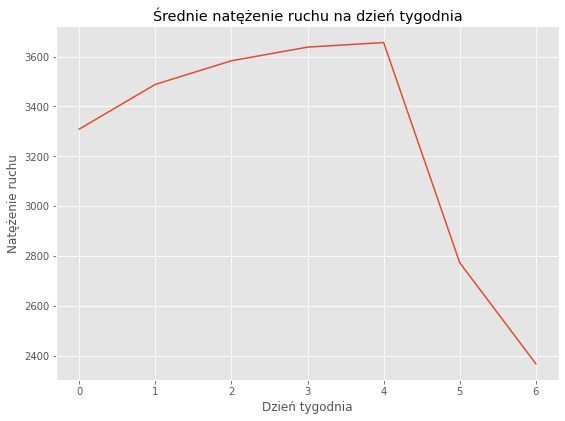

In [ ]:
plt.figure(figsize=(9,6.5))
df.groupby('week_day')['traffic_volume'].mean().plot.line()
plt.xlabel('Dzień tygodnia')
plt.ylabel('Natężenie ruchu')
plt.title('Średnie natężenie ruchu na dzień tygodnia')
plt.show()

Po obserwacji tego wykresu łatwo zauważyć, że większy ruch występuje w dni robocze (od poniedziałku do piątku). Znaczny spadek odnotowuje się na weekend, czyli w soboty i niedzielę. Ruch jest zmniejszony w tych dniach.

Porównamy okres dni roboczy i weekendu na wykresie, żeby zobaczyć jak wygląda tendecja w tych dniach.

In [ ]:
df['hour'] = df['date_time'].dt.hour
week = df.loc[df['week_day'] < 5]
weekend = df.loc[df['week_day'] >= 5]

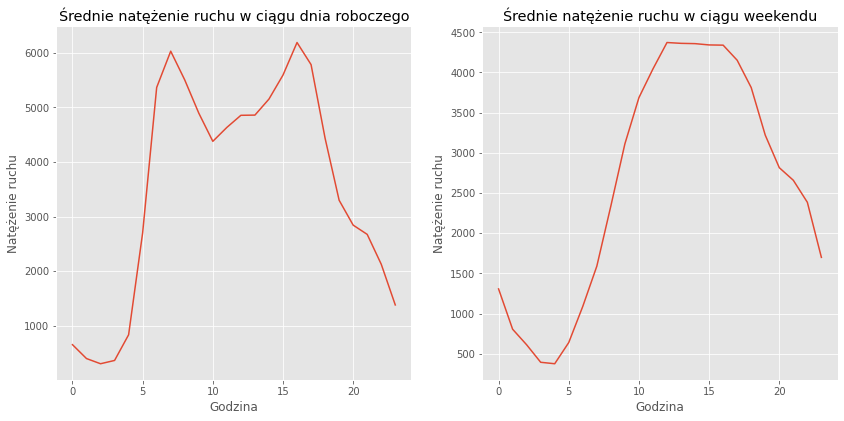

In [ ]:
plt.figure(figsize=(14,6.5))

plt.subplot(1, 2, 1)
plt.plot(week.groupby('hour')['traffic_volume'].mean())
plt.xlabel('Godzina')
plt.ylabel('Natężenie ruchu')
plt.title('Średnie natężenie ruchu w ciągu dnia roboczego')

plt.subplot(1, 2, 2)
plt.plot(weekend.groupby('hour')['traffic_volume'].mean())
plt.xlabel('Godzina')
plt.ylabel('Natężenie ruchu')
plt.title('Średnie natężenie ruchu w ciągu weekendu')
plt.show()

W ciągu dnia roboczego średnią największą częstotliwość odnotowuje się w godzinach pomiędzy 5 a 10 oraz pomiędzy 15 a 20.
W ciągu dnia weekendu wyraźny wzrost występuje pomiędzy godziną 5 aż do godziny 11/12, po którym ruch się stabilizuje i spada dopiero po godzinie 15.
Dodatkowo, w dzień weekendu jest większe natężenie na początku dnia (godzina 0).

## Weather Indicators

Inny wskaźnik warty analizy jest pogoda. Sprawdźmy korelacje wartości liczbowych powiązanych z pogodą znajdujących się w zbiorze danych z kolumną traffic_volume.

In [ ]:
day.corr()['traffic_volume']

temp              0.031393
rain_1h           0.003704
snow_1h           0.005008
clouds_all       -0.012465
traffic_volume    1.000000
month            -0.008365
year             -0.015641
Name: traffic_volume, dtype: float64

Największa korelacja jest z kolumną temp (temperatura). Pozostałymi kolumnami, w którym możemy dopatrywać korelacji jest rain_1h oraz snow_1h, ale są to małe wartości.

Skupimy się natomiast na temperaturze i stworzymy wykres rozrzutu.

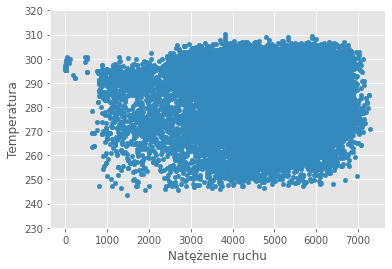

In [ ]:
day.plot.scatter('traffic_volume', 'temp')
plt.ylim(230, 320)
plt.xlabel('Natężenie ruchu')
plt.ylabel('Temperatura')
plt.show()

Temperatura nie wygląda na wskaźnik natężenia wartego dalszych analiz.

Przejdziemy więc do sprawdzenia kolumny weather_main.

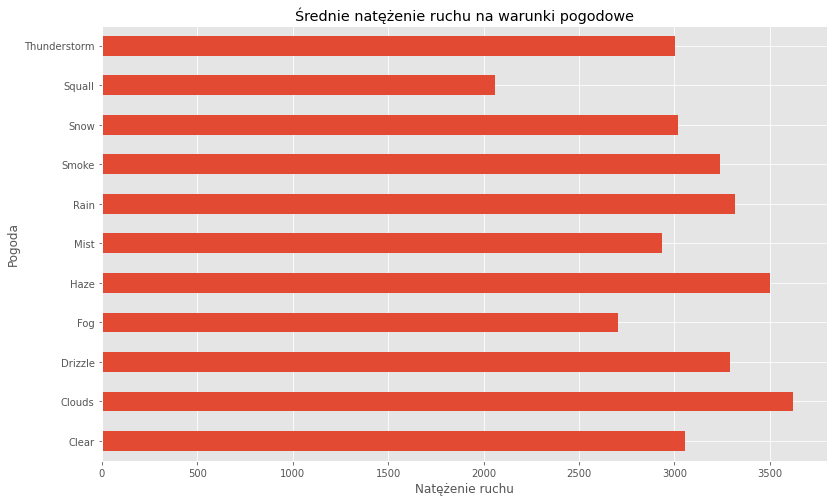

In [ ]:
weather = df.groupby('weather_main')['traffic_volume'].mean()

weather.plot.barh(figsize=(13,8))
plt.ylabel('Pogoda')
plt.xlabel('Natężenie ruchu')
plt.title('Średnie natężenie ruchu na warunki pogodowe')
plt.show()

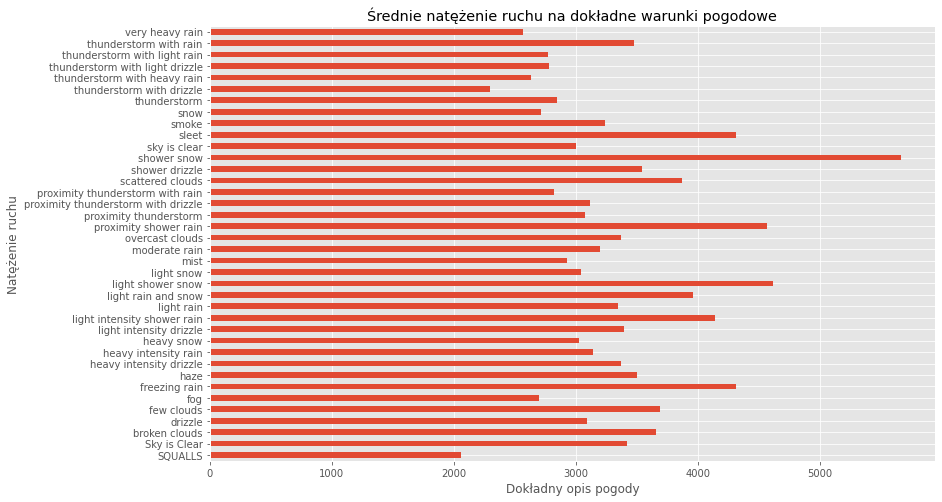

In [ ]:
by_weather_description = df.groupby('weather_description')['traffic_volume'].mean()


by_weather_description.plot.barh(figsize=(13,8))
plt.xlabel('Dokładny opis pogody')
plt.ylabel('Natężenie ruchu')
plt.title('Średnie natężenie ruchu na dokładne warunki pogodowe')
plt.show()

Największe wartości odnotowujemy podzas trawania pogody shower snow (śnieżyca). Inne warunki pogodowe sprzyjające większemu natężeniu ruchu to light rain and snow (lekki deszcz i śnieg) oraz proximity thunderstorm with drizzle (bliska burza z mżawką).
Najmniej wpływu ma squalls (wietrzyska) oraz thunderstorm with drizzle (burza z mżawką).

W ostateczności nie ma dużych rozbieżności w przypadku różnych zjawisk pogodowych. 

## Conclusion
Na tym etapie przestudiowaliśmy zbiór danych natężenia ruchu na drodze I-94.

Wnioski:
* Ruch jest większy w dni robocze.
* W dni robocze największą częstotliwość dopatruje się w godzinach  pomiędzy 5 a 10 oraz pomiędzy 15 a 20.
* Największy wpływ na ruch ze zjawisk pogodowych ma śnieżyca.
* Zazwyczaj ruch jest większy w cieplejszych miesiącach.
